<a href="https://colab.research.google.com/github/Dante-atc/Programa_Delfin/blob/main/EPOwMetaheuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing everyething! 🧑‍🎓💰🏛️🗠

Install libraries

In [ ]:
!pip install cma pygad deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.8 MB/s eta 0:00:00


Import libraries

In [ ]:
# NumPy and pandas for data manipulation and calculations
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Library for measuring execution time
import time

# Metaheuristics-specific libraries
import pygad
from scipy.optimize import differential_evolution
import cma


# Financial data download
import yfinance as yf


Prepare dataset and import financial data

In [ ]:
# Load ESG dataset
esg_csv_path = '/dataset/ESG_dataset.csv'
esg_df = pd.read_csv(
    esg_csv_path,
    usecols=['Symbol', 'Total ESG Risk score', 'ESG Risk Level']
)
esg_df = esg_df.dropna(subset=['Total ESG Risk score'])

symbols = esg_df['Symbol'].tolist()

start_date = '2020-01-01'
end_date = '2024-12-31'

# Download price data forcing auto_adjust=False
price_data_all = yf.download(
    symbols,
    start=start_date,
    end=end_date,
    group_by='ticker',
    progress=False,
    auto_adjust=False
)

adj_close_dict = {}

for ticker in symbols:
    if ticker in price_data_all.columns.levels[0]:
        try:
            adj_close = price_data_all[ticker]['Adj Close']
            if not adj_close.isnull().all():
                adj_close_dict[ticker] = adj_close
            else:
                print(f"No valid Adj Close for {ticker}")
        except KeyError:
            print(f"No Adj Close column for {ticker}")
    else:
        print(f"Ticker {ticker} not in downloaded data")

# Create DataFrame with adjusted close prices
if adj_close_dict:
    price_data = pd.DataFrame(adj_close_dict)
else:
    price_data = pd.DataFrame()

# Calculate daily returns (drop rows where all symbols have NaN)
returns = price_data.pct_change().dropna(how='all')

# Match common symbols between returns and ESG data
common_symbols = list(set(returns.columns).intersection(esg_df['Symbol']))

returns = returns[common_symbols]
esg_df = esg_df[esg_df['Symbol'].isin(common_symbols)]

# Reorder ESG df to match returns columns order
esg_df = esg_df.set_index('Symbol').loc[common_symbols]

esg_scores = esg_df['Total ESG Risk score'].values

print(f"Data loaded for {len(common_symbols)} companies.")
print(returns.head())
print(esg_df[['Total ESG Risk score', 'ESG Risk Level']].head())



Data loaded for 427 companies.
                 GPN       LEN      PCAR       PPG       MRK      ADSK  \
Date                                                                     
2020-01-03 -0.006840  0.011826 -0.009810 -0.014514 -0.008584 -0.015333   
2020-01-06  0.019360  0.027979 -0.003684 -0.004626  0.004274  0.011733   
2020-01-07 -0.003192 -0.015676 -0.006629 -0.007824 -0.026626  0.002031   
2020-01-08  0.007952  0.007875  0.013347  0.002576 -0.006727  0.013067   
2020-01-09  0.013290  0.001736 -0.006459  0.001947  0.008804  0.010476   

                FAST       BMY       BAC      BIIB  ...       DHR       WMT  \
Date                                                ...                       
2020-01-03 -0.017727 -0.008841 -0.020763 -0.011521  ... -0.006189 -0.008828   
2020-01-06 -0.015587  0.003186 -0.001433 -0.000103  ...  0.002984 -0.002036   
2020-01-07 -0.001944  0.015084 -0.006600 -0.002510  ...  0.009831 -0.009265   
2020-01-08  0.007515 -0.001095  0.010110  0.008859  ...

Prepare data for use and test general fitness of dataset

In [ ]:
from sklearn.metrics import r2_score

# Normalize ESG risk scores
esg_norm = esg_scores / 100.0

# Get returns matrix
asset_returns_matrix = returns.values

# Benchmark Returns
benchmark_ticker = "^GSPC"

benchmark_data = yf.download(
    benchmark_ticker,
    start=start_date,
    end=end_date,
    progress=False
)

benchmark_returns = benchmark_data['Close'].pct_change().dropna()

# Align Dates
benchmark_returns = benchmark_returns.loc[returns.index]

real_returns = benchmark_returns.values

# Weights Initialization
n_assets = asset_returns_matrix.shape[1]

# Equal starting weights
weights = np.ones(n_assets) / n_assets

#  Fitness Function Definitions
def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty


# Example Call
lambda_penalty = 1.5

score = fitness(
    weights,
    real_returns,
    asset_returns_matrix,
    esg_norm,
    lambda_penalty
)

print("Fitness example:", score)

/tmp/ipython-input-4-4279741569.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(


Fitness example: -0.5593690329705563


# Genetic Algorithm 🧬🖥️

GA implementation

In [ ]:
# GA Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def tournament_selection(population, fitness_scores, k):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmin(fitness_scores[selected])]
    return population[best]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    child = alpha * parent1 + (1 - alpha) * parent2
    return normalize(child)

def mutate(weights, rate):
    mutation = np.random.normal(0, rate, size=weights.shape)
    mutated = weights + mutation
    return normalize(mutated)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


GA Implementation

In [ ]:
# Execution
population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):
    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    best_idx = np.argmin(fitness_scores)
    best_individual = population[best_idx]
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(
        real_returns,
        asset_returns_matrix @ best_individual
    )
    best_penalty = compute_esg_penalty(best_individual, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )

    new_population = []
    while len(new_population) < POPULATION_SIZE:
        parent1 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        parent2 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        child = crossover(parent1, parent2)
        child = mutate(child, MUTATION_RATE)
        new_population.append(child)

    population = np.array(new_population)

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = population[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")

Gen 0: Fitness=-0.5724, R2=0.8947, ESG Penalty=0.2149
Gen 10: Fitness=-0.5777, R2=0.8884, ESG Penalty=0.2071
Gen 20: Fitness=-0.5859, R2=0.9052, ESG Penalty=0.2129
Gen 30: Fitness=-0.5812, R2=0.8967, ESG Penalty=0.2103
Gen 40: Fitness=-0.6119, R2=0.9275, ESG Penalty=0.2104
Gen 50: Fitness=-0.5860, R2=0.8973, ESG Penalty=0.2075
Gen 60: Fitness=-0.6017, R2=0.9118, ESG Penalty=0.2068
Gen 70: Fitness=-0.5954, R2=0.9070, ESG Penalty=0.2077
Gen 80: Fitness=-0.5914, R2=0.9099, ESG Penalty=0.2123
Gen 90: Fitness=-0.5908, R2=0.9080, ESG Penalty=0.2114
Gen 100: Fitness=-0.5901, R2=0.8995, ESG Penalty=0.2063
Gen 110: Fitness=-0.5894, R2=0.9064, ESG Penalty=0.2113
Gen 120: Fitness=-0.5853, R2=0.8927, ESG Penalty=0.2049
Gen 130: Fitness=-0.6102, R2=0.9175, ESG Penalty=0.2049
Gen 140: Fitness=-0.5980, R2=0.9080, ESG Penalty=0.2067
Gen 150: Fitness=-0.5894, R2=0.9011, ESG Penalty=0.2078
Gen 160: Fitness=-0.6037, R2=0.9099, ESG Penalty=0.2041
Gen 170: Fitness=-0.5992, R2=0.9068, ESG Penalty=0.2050
Gen

Full portfolio description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)



=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0       DE  0.014731                  20.0            Low
1      NOW  0.014634                  16.6            Low
2      WMB  0.014406                  21.8         Medium
3     PARA  0.013086                  15.0            Low
4      YUM  0.012526                  20.1         Medium
..     ...       ...                   ...            ...
214   MNST  0.000380                  29.2         Medium
215    USB  0.000316                  30.3           High
216    AAL  0.000256                  26.4         Medium
217     KR  0.000223                  21.3         Medium
218   CTAS  0.000150                  18.1            Low

[219 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"

final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values

final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")


Testing your optimized portfolio on 2025 with 219 assets...


/tmp/ipython-input-8-3204530070.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8791
Expected Return (annualized): 15.7256%
Standard Deviation (annualized): 21.9541%
Sharpe Ratio: 0.7163
Maximum Drawdown (MDD): -15.2643%
Average ESG Score (weighted): 21.4883


/tmp/ipython-input-8-3204530070.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of GA Prediction vs Real 2025 Performance ===
                Fitness        R²  Expected Return (annualized %)  \
GA Prediction -0.603771  0.871510                       16.123978   
Real 2025           NaN  0.879071                       15.725571   

               Standard Deviation (annualized %)  Sharpe Ratio  \
GA Prediction                          22.737483      0.709136   
Real 2025                              21.954126      0.716292   

               Maximum Drawdown (MDD %)  
GA Prediction                -39.687806  
Real 2025                    -15.264309  


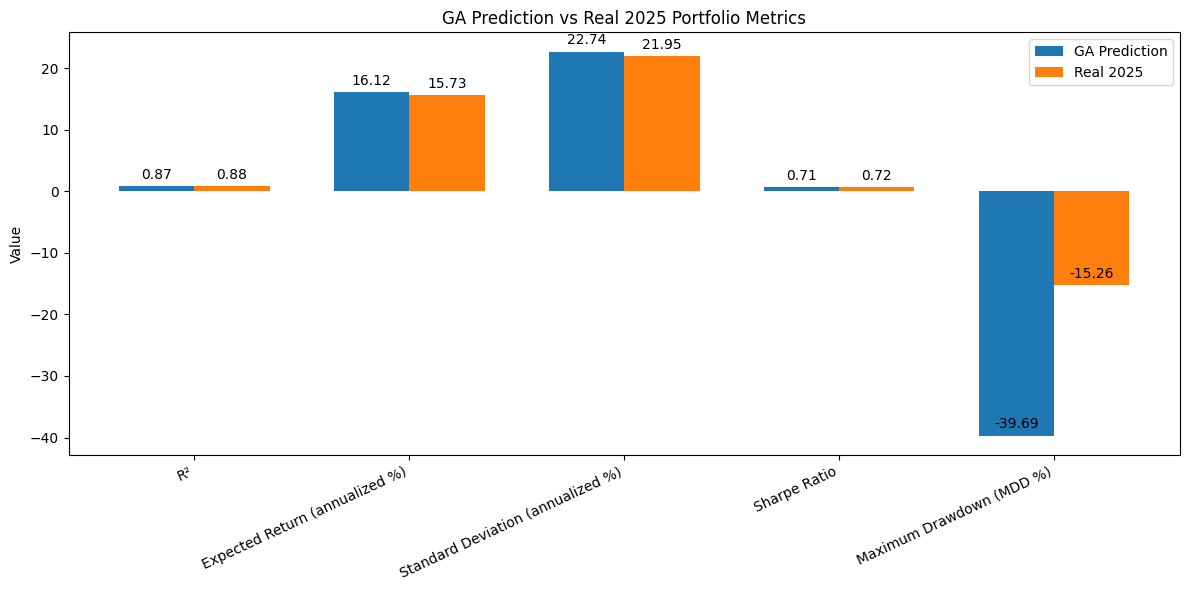

In [ ]:
# GA results
ga_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "GA Prediction": ga_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of GA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

ga_vals = [ga_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, ga_vals, width, label='GA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('GA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Elitist Genetic Algorithm 🧬🖥️🎩

Parameters

In [ ]:
# Elitist GA Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def tournament_selection(population, fitness_scores, k):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmin(fitness_scores[selected])]
    return population[best]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    child = alpha * parent1 + (1 - alpha) * parent2
    return normalize(child)

def mutate(weights, rate):
    mutation = np.random.normal(0, rate, size=weights.shape)
    mutated = weights + mutation
    return normalize(mutated)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


Elitist GA implementation

In [ ]:
# Execution
population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

ELITISM_RATE = 0.05
elitism_size = max(1, int(POPULATION_SIZE * ELITISM_RATE))

start_time = time.time()

for generation in range(N_GENERATIONS):
    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    best_idx = np.argmin(fitness_scores)
    best_individual = population[best_idx]
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(
        real_returns,
        asset_returns_matrix @ best_individual
    )
    best_penalty = compute_esg_penalty(best_individual, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )


    sorted_indices = np.argsort(fitness_scores)
    elite_individuals = population[sorted_indices[:elitism_size]]


    new_population = list(elite_individuals)

    while len(new_population) < POPULATION_SIZE:
        parent1 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        parent2 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        child = crossover(parent1, parent2)
        child = mutate(child, MUTATION_RATE)
        new_population.append(child)

    population = np.array(new_population)

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = population[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Gen 0: Fitness=-0.5680, R2=0.8894, ESG Penalty=0.2142
Gen 10: Fitness=-0.6053, R2=0.9132, ESG Penalty=0.2052
Gen 20: Fitness=-0.6125, R2=0.9199, ESG Penalty=0.2049
Gen 30: Fitness=-0.6125, R2=0.9199, ESG Penalty=0.2049
Gen 40: Fitness=-0.6125, R2=0.9199, ESG Penalty=0.2049
Gen 50: Fitness=-0.6125, R2=0.9199, ESG Penalty=0.2049
Gen 60: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 70: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 80: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 90: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 100: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 110: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 120: Fitness=-0.6125, R2=0.9210, ESG Penalty=0.2057
Gen 130: Fitness=-0.6152, R2=0.9300, ESG Penalty=0.2099
Gen 140: Fitness=-0.6152, R2=0.9300, ESG Penalty=0.2099
Gen 150: Fitness=-0.6152, R2=0.9300, ESG Penalty=0.2099
Gen 160: Fitness=-0.6152, R2=0.9300, ESG Penalty=0.2099
Gen 170: Fitness=-0.6152, R2=0.9300, ESG Penalty=0.2099
Gen

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)



=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0      MKC  0.016120                  26.1         Medium
1      ABT  0.015209                  24.8         Medium
2       GS  0.014509                  25.5         Medium
3       HD  0.013757                  12.6            Low
4      MCK  0.013692                  15.2            Low
..     ...       ...                   ...            ...
214    PNC  0.000305                  26.1         Medium
215    ALL  0.000282                  22.0         Medium
216    BXP  0.000247                  12.5            Low
217    WAT  0.000171                  14.6            Low
218    KMI  0.000148                  19.0            Low

[219 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values

final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
          sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
          sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")


Testing your optimized portfolio on 2025 with 219 assets...


/tmp/ipython-input-13-2394625584.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.9022
Expected Return (annualized): 16.8245%
Standard Deviation (annualized): 21.8432%
Sharpe Ratio: 0.7702
Maximum Drawdown (MDD): -15.5160%
Average ESG Score (weighted): 20.9887


/tmp/ipython-input-13-2394625584.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of Elitist GA Prediction vs Real 2025 Performance ===
                        Fitness        R²  Expected Return (annualized %)  \
Elitist GA Prediction -0.615162  0.930018                       16.964346   
Real 2025                   NaN  0.902213                       16.824471   

                       Standard Deviation (annualized %)  Sharpe Ratio  \
Elitist GA Prediction                          21.793657      0.778407   
Real 2025                                      21.843177      0.770239   

                       Maximum Drawdown (MDD %)  
Elitist GA Prediction                -36.307212  
Real 2025                            -15.516032  


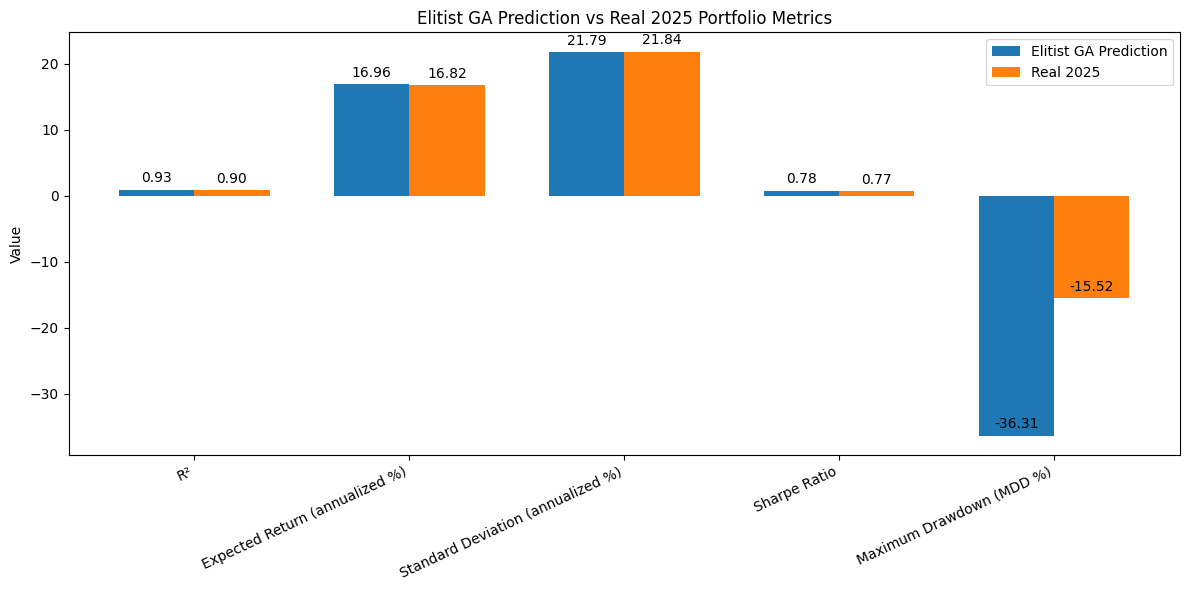

In [ ]:
# Elitist GA results
ga_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "Elitist GA Prediction": ga_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of Elitist GA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

ga_vals = [ga_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, ga_vals, width, label='Elitist GA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('Elitist GA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Adaptive Genetic Algorithm 🧬🖥️💡

Parameters

In [ ]:
# Adaptive GA Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
BASE_MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def tournament_selection(population, fitness_scores, k):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmin(fitness_scores[selected])]
    return population[best]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    child = alpha * parent1 + (1 - alpha) * parent2
    return normalize(child)

def mutate(weights, rate):
    mutation = np.random.normal(0, rate, size=weights.shape)
    mutated = weights + mutation
    return normalize(mutated)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Adaptive Mutation Rate
def adaptive_mutation_rate(current_gen, best_fitness, worst_fitness, base_rate=BASE_MUTATION_RATE):
    if best_fitness == worst_fitness:
        return base_rate
    diversity = (worst_fitness - best_fitness) / abs(worst_fitness)
    return min(0.5, base_rate + diversity)


Adaptive GA implementation

In [ ]:
# Execution

population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):

    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    best_idx = np.argmin(fitness_scores)
    worst_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    worst_fitness = fitness_scores[worst_idx]

    if best_fitness == worst_fitness:
        adaptive_rate = BASE_MUTATION_RATE
    else:
        diversity = (worst_fitness - best_fitness) / abs(worst_fitness)
        adaptive_rate = min(0.5, BASE_MUTATION_RATE + diversity)

    best_individual = population[best_idx]

    best_r2 = compute_r2(
        real_returns,
        asset_returns_matrix @ best_individual
    )
    best_penalty = compute_esg_penalty(best_individual, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, "
            f"ESG Penalty={best_penalty:.4f}, Adaptive Mutation Rate={adaptive_rate:.4f}"
        )

    new_population = []

    while len(new_population) < POPULATION_SIZE:
        parent1 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        parent2 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        child = crossover(parent1, parent2)
        child = mutate(child, adaptive_rate)
        new_population.append(child)

    population = np.array(new_population)

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = population[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")



Gen 0: Fitness=-0.5723, R2=0.8919, ESG Penalty=0.2131, Adaptive Mutation Rate=0.1613
Gen 10: Fitness=-0.5983, R2=0.9050, ESG Penalty=0.2045, Adaptive Mutation Rate=0.2888
Gen 20: Fitness=-0.5907, R2=0.9062, ESG Penalty=0.2103, Adaptive Mutation Rate=0.3157
Gen 30: Fitness=-0.5947, R2=0.9058, ESG Penalty=0.2074, Adaptive Mutation Rate=0.2870
Gen 40: Fitness=-0.5959, R2=0.9088, ESG Penalty=0.2086, Adaptive Mutation Rate=0.2769
Gen 50: Fitness=-0.6037, R2=0.9124, ESG Penalty=0.2058, Adaptive Mutation Rate=0.2912
Gen 60: Fitness=-0.5977, R2=0.9010, ESG Penalty=0.2022, Adaptive Mutation Rate=0.2934
Gen 70: Fitness=-0.5911, R2=0.9026, ESG Penalty=0.2077, Adaptive Mutation Rate=0.2647
Gen 80: Fitness=-0.5938, R2=0.9096, ESG Penalty=0.2105, Adaptive Mutation Rate=0.2467
Gen 90: Fitness=-0.5972, R2=0.9128, ESG Penalty=0.2104, Adaptive Mutation Rate=0.3278
Gen 100: Fitness=-0.5994, R2=0.9058, ESG Penalty=0.2043, Adaptive Mutation Rate=0.2875
Gen 110: Fitness=-0.5785, R2=0.8944, ESG Penalty=0.210

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0     APTV  0.018792                  10.7            Low
1       BR  0.017908                  16.6            Low
2       PM  0.016313                  28.5         Medium
3      OMC  0.014448                  16.3            Low
4      UHS  0.013132                  33.0           High
..     ...       ...                   ...            ...
215    BRO  0.000251                  20.5         Medium
216    REG  0.000242                  11.7            Low
217     PG  0.000166                  28.6         Medium
218   ANSS  0.000155                  15.9            Low
219      A  0.000147                  13.6            Low

[220 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 220 assets...


/tmp/ipython-input-18-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8737
Expected Return (annualized): 11.1216%
Standard Deviation (annualized): 21.9982%
Sharpe Ratio: 0.5056
Maximum Drawdown (MDD): -15.7210%
Average ESG Score (weighted): 20.7989


/tmp/ipython-input-18-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of Adaptive GA Prediction vs Real 2025 Performance ===
                         Fitness        R²  Expected Return (annualized %)  \
Adaptive GA Prediction -0.593083  0.879008                       15.398195   
Real 2025                    NaN  0.873747                       11.121598   

                        Standard Deviation (annualized %)  Sharpe Ratio  \
Adaptive GA Prediction                          22.495701      0.684495   
Real 2025                                       21.998243      0.505568   

                        Maximum Drawdown (MDD %)  
Adaptive GA Prediction                -38.351485  
Real 2025                             -15.721031  


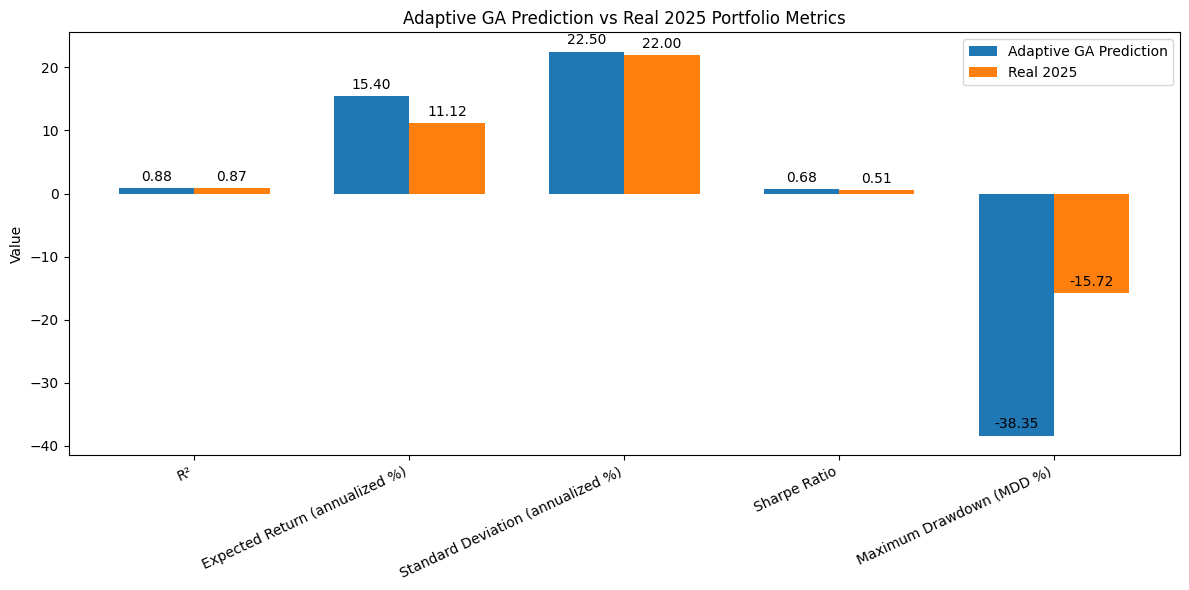

In [ ]:
# Adaptive GA results
ga_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "Adaptive GA Prediction": ga_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of Adaptive GA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

ga_vals = [ga_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, ga_vals, width, label='Adaptive GA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('Adaptive GA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Adaptive/Elitist Genetic Algorithm 🧬🖥️💡🎩

Parameters

In [ ]:
# Adaptive GA Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
BASE_MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def tournament_selection(population, fitness_scores, k):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmin(fitness_scores[selected])]
    return population[best]

def crossover(parent1, parent2):
    alpha = np.random.rand()
    child = alpha * parent1 + (1 - alpha) * parent2
    return normalize(child)

def mutate(weights, rate):
    mutation = np.random.normal(0, rate, size=weights.shape)
    mutated = weights + mutation
    return normalize(mutated)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Adaptive Mutation Rate
def adaptive_mutation_rate(current_gen, best_fitness, worst_fitness, base_rate=BASE_MUTATION_RATE):
    if best_fitness == worst_fitness:
        return base_rate
    diversity = (worst_fitness - best_fitness) / abs(worst_fitness)
    return min(0.5, base_rate + diversity)


Adaptive/Elitist GA implementation

In [ ]:
# Execution

population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

ELITISM_RATE = 0.05
elitism_size = max(1, int(POPULATION_SIZE * ELITISM_RATE))

start_time = time.time()

for generation in range(N_GENERATIONS):

    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    best_idx = np.argmin(fitness_scores)
    worst_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    worst_fitness = fitness_scores[worst_idx]

    if best_fitness == worst_fitness:
        adaptive_rate = BASE_MUTATION_RATE
    else:
        diversity = (worst_fitness - best_fitness) / abs(worst_fitness)
        adaptive_rate = min(0.5, BASE_MUTATION_RATE + diversity)

    best_individual = population[best_idx]

    best_r2 = compute_r2(
        real_returns,
        asset_returns_matrix @ best_individual
    )
    best_penalty = compute_esg_penalty(best_individual, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, "
            f"ESG Penalty={best_penalty:.4f}, Adaptive Mutation Rate={adaptive_rate:.4f}"
        )


    sorted_indices = np.argsort(fitness_scores)
    elite_individuals = population[sorted_indices[:elitism_size]]


    new_population = list(elite_individuals)

    while len(new_population) < POPULATION_SIZE:
        parent1 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        parent2 = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        child = crossover(parent1, parent2)
        child = mutate(child, adaptive_rate)
        new_population.append(child)

    population = np.array(new_population)

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = population[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Gen 0: Fitness=-0.5820, R2=0.8988, ESG Penalty=0.2112, Adaptive Mutation Rate=0.1700
Gen 10: Fitness=-0.5984, R2=0.9156, ESG Penalty=0.2115, Adaptive Mutation Rate=0.2580
Gen 20: Fitness=-0.6052, R2=0.9129, ESG Penalty=0.2052, Adaptive Mutation Rate=0.2862
Gen 30: Fitness=-0.6052, R2=0.9129, ESG Penalty=0.2052, Adaptive Mutation Rate=0.2959
Gen 40: Fitness=-0.6052, R2=0.9129, ESG Penalty=0.2052, Adaptive Mutation Rate=0.3262
Gen 50: Fitness=-0.6052, R2=0.9129, ESG Penalty=0.2052, Adaptive Mutation Rate=0.2778
Gen 60: Fitness=-0.6052, R2=0.9129, ESG Penalty=0.2052, Adaptive Mutation Rate=0.3561
Gen 70: Fitness=-0.6083, R2=0.9157, ESG Penalty=0.2049, Adaptive Mutation Rate=0.3248
Gen 80: Fitness=-0.6086, R2=0.9256, ESG Penalty=0.2113, Adaptive Mutation Rate=0.3266
Gen 90: Fitness=-0.6086, R2=0.9256, ESG Penalty=0.2113, Adaptive Mutation Rate=0.2878
Gen 100: Fitness=-0.6086, R2=0.9256, ESG Penalty=0.2113, Adaptive Mutation Rate=0.2829
Gen 110: Fitness=-0.6086, R2=0.9256, ESG Penalty=0.211

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0      CMG  0.027060                  20.7         Medium
1      HPQ  0.020489                  11.3            Low
2      ADP  0.016168                  13.8            Low
3      AFL  0.015675                  18.3            Low
4      HUM  0.014582                  22.5         Medium
..     ...       ...                   ...            ...
197   FFIV  0.000318                  17.1            Low
198   DXCM  0.000245                  24.0         Medium
199   VRTX  0.000214                  22.7         Medium
200    ETR  0.000167                  26.7         Medium
201   PARA  0.000123                  15.0            Low

[202 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"

final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values

final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 202 assets...


/tmp/ipython-input-23-3994095066.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8854
Expected Return (annualized): 13.0180%
Standard Deviation (annualized): 21.6501%
Sharpe Ratio: 0.6013
Maximum Drawdown (MDD): -15.6083%
Average ESG Score (weighted): 19.7875


/tmp/ipython-input-23-3994095066.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of Adaptive/Elitist GA Prediction vs Real 2025 Performance ===
                                 Fitness        R²  \
Adaptive/Elitist GA Prediction -0.627394  0.924266   
Real 2025                            NaN  0.885447   

                                Expected Return (annualized %)  \
Adaptive/Elitist GA Prediction                       14.712878   
Real 2025                                            13.017986   

                                Standard Deviation (annualized %)  \
Adaptive/Elitist GA Prediction                          21.517641   
Real 2025                                               21.650088   

                                Sharpe Ratio  Maximum Drawdown (MDD %)  
Adaptive/Elitist GA Prediction      0.683759                -34.885722  
Real 2025                           0.601290                -15.608297  


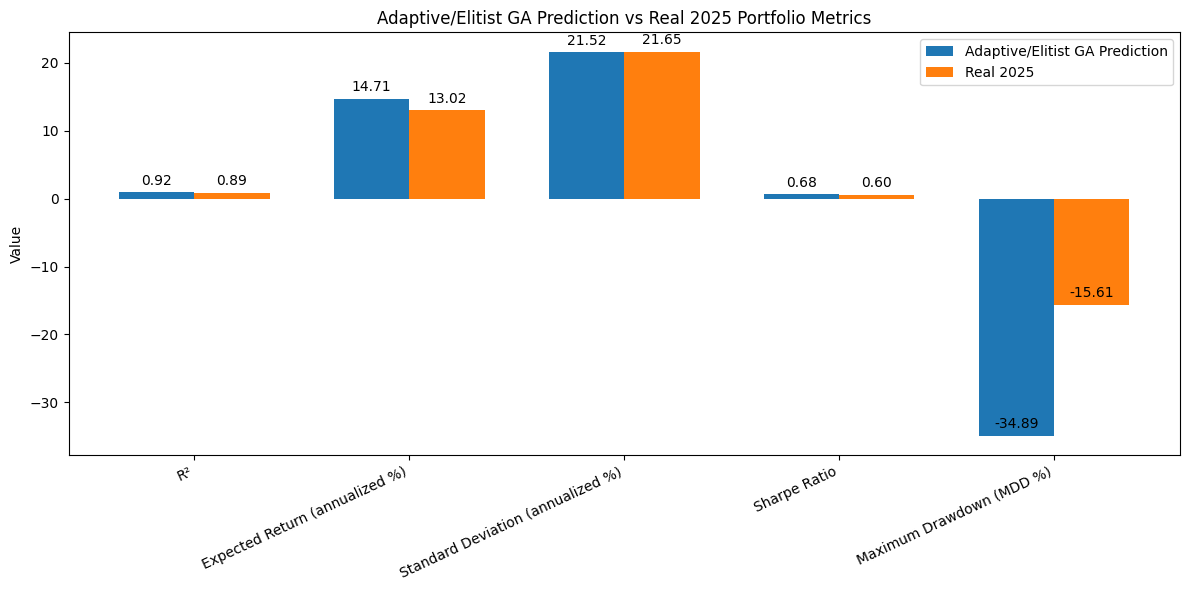

In [ ]:
# Adaptive/Elitist GA results
ga_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "Adaptive/Elitist GA Prediction": ga_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of Adaptive/Elitist GA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

ga_vals = [ga_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, ga_vals, width, label='Adaptive/Elitist GA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('Adaptive/Elitist GA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Differential Evolution 🧬🖥️🔧

Parametros

In [ ]:
# DE Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
SCALING_FACTOR = 0.8
CROSSOVER_RATE = 0.7
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions

def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


Differential Evolution Implementation

In [ ]:
# Execution

population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):

    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    new_population = []

    for i in range(POPULATION_SIZE):
        # Select 3 distinct individuals (r1, r2, r3) different from i
        indices = list(range(POPULATION_SIZE))
        indices.remove(i)
        r1, r2, r3 = np.random.choice(indices, size=3, replace=False)

        # Mutation
        mutant = population[r1] + SCALING_FACTOR * (population[r2] - population[r3])
        mutant = normalize(mutant)

        # Crossover
        crossover_mask = np.random.rand(n_assets) < CROSSOVER_RATE
        trial = np.where(crossover_mask, mutant, population[i])
        trial = normalize(trial)

        # Evaluate fitness
        trial_fitness = fitness(trial, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)

        # Selection
        if trial_fitness < fitness_scores[i]:
            new_population.append(trial)
        else:
            new_population.append(population[i])

    population = np.array(new_population)

    # Track best individual
    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])
    best_idx = np.argmin(fitness_scores)
    best_individual = population[best_idx]
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(real_returns, asset_returns_matrix @ best_individual)
    best_penalty = compute_esg_penalty(best_individual, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = population[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results - Differential Evolution ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Gen 0: Fitness=-0.5767, R2=0.8947, ESG Penalty=0.2121
Gen 10: Fitness=-0.6061, R2=0.9204, ESG Penalty=0.2096
Gen 20: Fitness=-0.6362, R2=0.9280, ESG Penalty=0.1945
Gen 30: Fitness=-0.6568, R2=0.9450, ESG Penalty=0.1921
Gen 40: Fitness=-0.6693, R2=0.9513, ESG Penalty=0.1880
Gen 50: Fitness=-0.6848, R2=0.9571, ESG Penalty=0.1816
Gen 60: Fitness=-0.6952, R2=0.9605, ESG Penalty=0.1768
Gen 70: Fitness=-0.6998, R2=0.9589, ESG Penalty=0.1727
Gen 80: Fitness=-0.7078, R2=0.9610, ESG Penalty=0.1688
Gen 90: Fitness=-0.7109, R2=0.9694, ESG Penalty=0.1723
Gen 100: Fitness=-0.7132, R2=0.9651, ESG Penalty=0.1679
Gen 110: Fitness=-0.7191, R2=0.9709, ESG Penalty=0.1679
Gen 120: Fitness=-0.7233, R2=0.9685, ESG Penalty=0.1635
Gen 130: Fitness=-0.7298, R2=0.9647, ESG Penalty=0.1566
Gen 140: Fitness=-0.7298, R2=0.9647, ESG Penalty=0.1566
Gen 150: Fitness=-0.7298, R2=0.9647, ESG Penalty=0.1566
Gen 160: Fitness=-0.7330, R2=0.9683, ESG Penalty=0.1569
Gen 170: Fitness=-0.7339, R2=0.9654, ESG Penalty=0.1543
Gen

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0     MSFT  0.075515                  15.1            Low
1     AAPL  0.062761                  17.2            Low
2      COR  0.045080                  12.8            Low
3      ACN  0.040745                   9.8     Negligible
4     NVDA  0.037251                  13.6            Low
..     ...       ...                   ...            ...
242    KEY  0.000110                  21.4         Medium
243    NUE  0.000107                  32.8           High
244   CHRW  0.000106                  19.3            Low
245    MLM  0.000103                  30.1           High
246    FTV  0.000102                  34.8           High

[247 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 247 assets...


/tmp/ipython-input-28-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(
/tmp/ipython-input-28-3013261169.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2025 = adj_close_2025.pct_change().dropna()
/tmp/ipython-input-28-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.9445
Expected Return (annualized): 14.6882%
Standard Deviation (annualized): 22.1338%
Sharpe Ratio: 0.6636
Maximum Drawdown (MDD): -16.8185%
Average ESG Score (weighted): 13.9486


Real vs. Predicted Values Visualization

=== Comparison of DE Prediction vs Real 2025 Performance ===
                Fitness        R²  Expected Return (annualized %)  \
DE Prediction -0.757403  0.967253                       20.377028   
Real 2025           NaN  0.944526                       14.688192   

               Standard Deviation (annualized %)  Sharpe Ratio  \
DE Prediction                          22.144193      0.920197   
Real 2025                              22.133786      0.663610   

               Maximum Drawdown (MDD %)  
DE Prediction                -33.117691  
Real 2025                    -16.818548  


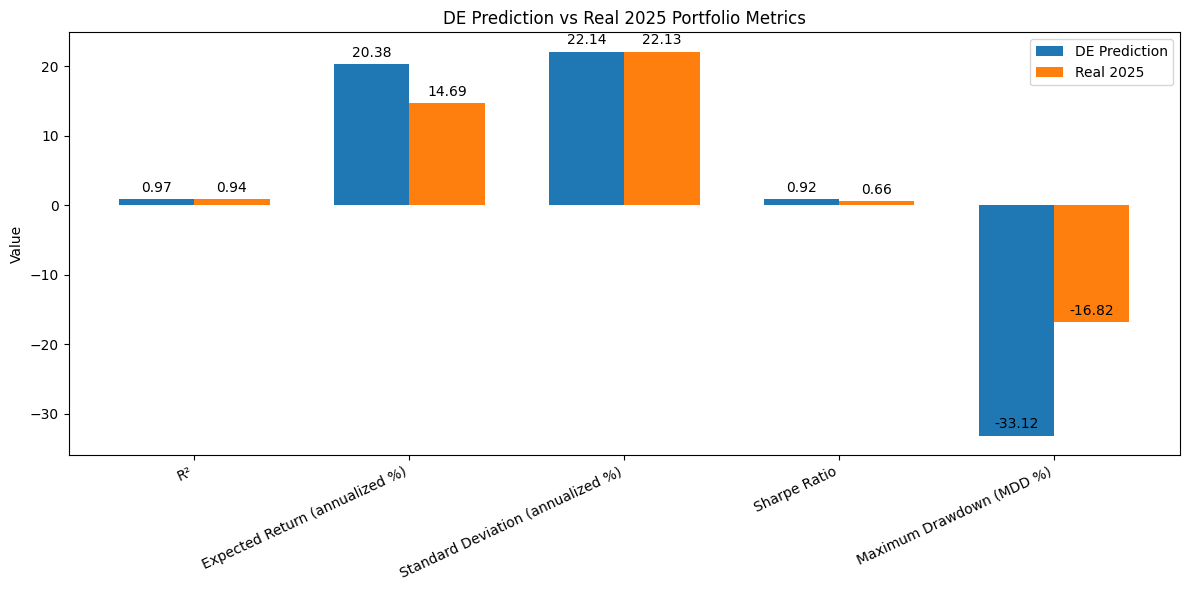

In [ ]:
# DE results
de_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "DE Prediction": de_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of DE Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

de_vals = [de_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, de_vals, width, label='DE Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('DE Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Black Hole Mechanics Optimization Algorithm (BHMO) 🌌🖥️

Parameters

In [ ]:

POPULATION_SIZE = 50
N_ITERATIONS = 500
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions

def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(pop_size, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(pop_size)])

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    return mean_daily * 252

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    return daily_std * np.sqrt(252)

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    return (exp_ret - risk_free_rate) / std_dev if std_dev > 0 else 0

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


BHMO Implementation

In [ ]:
population = initialize_population(POPULATION_SIZE, n_assets)

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for iteration in range(N_ITERATIONS):

    # Evaluate fitness of all stars
    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in population
    ])

    # Identify the Black Hole (the best individual)
    best_idx = np.argmin(fitness_scores)
    black_hole = population[best_idx].copy()
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(real_returns, asset_returns_matrix @ black_hole)
    best_penalty = compute_esg_penalty(black_hole, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    # Compute radius of event horizon (absorbing radius)
    total_fitness = np.sum(fitness_scores - fitness_scores.min() + 1e-8)
    radius = best_fitness / total_fitness if total_fitness > 0 else 0.01

    # Move stars towards the black hole
    new_population = []

    for i in range(POPULATION_SIZE):
        if i == best_idx:
            new_population.append(black_hole)
            continue

        star = population[i]
        # Move star closer to black hole
        new_star = star + np.random.rand() * (black_hole - star)
        new_star = normalize(new_star)

        # Compute Euclidean distance
        distance = np.linalg.norm(new_star - black_hole)

        # Absorb star if inside event horizon
        if distance < radius:
            new_star = normalize(np.random.rand(n_assets))

        new_population.append(new_star)

    population = np.array(new_population)

    if iteration % 10 == 0 or iteration == N_ITERATIONS - 1:
        print(
            f"Iter {iteration}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )

end_time = time.time()
exec_time = end_time - start_time

# Compute metrics for final black hole
final_best_weights = black_hole
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results (BHMO) ====")
print(f"Fitness: {best_fitness:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Iter 0: Fitness=-0.5697, R2=0.8921, ESG Penalty=0.2149
Iter 10: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 20: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 30: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 40: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 50: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 60: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 70: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 80: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 90: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 100: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 110: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 120: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 130: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 140: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 150: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 160: Fitness=-0.5703, R2=0.8915, ESG Penalty=0.2141
Iter 170: Fitness=-0.5703, R2=0.8915, ESG 

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0      ECL  0.004402                  19.9            Low
1     GILD  0.004359                  23.0         Medium
2     NDAQ  0.004312                  13.1            Low
3      TXT  0.004312                  33.6           High
4        V  0.004275                  16.7            Low
..     ...       ...                   ...            ...
422     FE  0.000318                  25.6         Medium
423    MCO  0.000306                  15.8            Low
424    RCL  0.000267                  20.7         Medium
425    CAH  0.000263                  14.9            Low
426    TPR  0.000217                  14.8            Low

[427 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 427 assets...


/tmp/ipython-input-33-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8737
Expected Return (annualized): 13.0194%
Standard Deviation (annualized): 21.8586%
Sharpe Ratio: 0.5956
Maximum Drawdown (MDD): -15.4505%
Average ESG Score (weighted): 21.4136


/tmp/ipython-input-33-3013261169.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2025 = adj_close_2025.pct_change().dropna()
/tmp/ipython-input-33-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of BHMO Prediction vs Real 2025 Performance ===
                  Fitness        R²  Expected Return (annualized %)  \
BHMO Prediction -0.570327  0.891531                       15.304867   
Real 2025             NaN  0.873673                       13.019376   

                 Standard Deviation (annualized %)  Sharpe Ratio  \
BHMO Prediction                          22.061033      0.693751   
Real 2025                                21.858594      0.595618   

                 Maximum Drawdown (MDD %)  
BHMO Prediction                -37.945358  
Real 2025                      -15.450536  


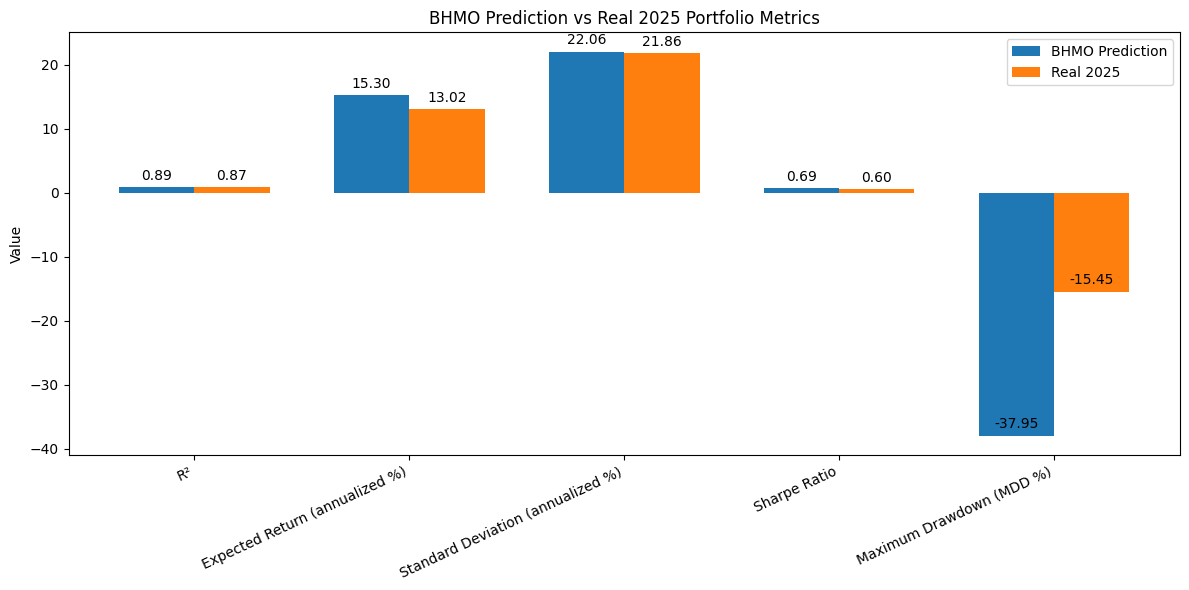

In [ ]:
# BHMO results
bhmo_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "BHMO Prediction": bhmo_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of BHMO Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

bhmo_vals = [bhmo_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, bhmo_vals, width, label='BHMO Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('BHMO Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# CMA-ES 📐🖥️🏫

Parameters

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# CMA-ES Parameters
POPULATION_SIZE = 50
N_GENERATIONS = 500
SIGMA_INIT = 0.3
LAMBDA_PENALTY = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions

def normalize(weights):
    weights = np.maximum(weights, 0)
    if np.sum(weights) == 0:
        return np.ones_like(weights) / len(weights)
    return weights / np.sum(weights)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = normalize(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


CMA-ES Implementation

In [ ]:
esigma = SIGMA_INIT
es = cma.CMAEvolutionStrategy(n_assets * [1.0 / n_assets], esigma, {'popsize': POPULATION_SIZE})

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):
    solutions = es.ask()
    fitness_scores = np.array([
        fitness(np.array(sol), real_returns, asset_returns_matrix, esg_norm, LAMBDA_PENALTY)
        for sol in solutions
    ])

    es.tell(solutions, fitness_scores.tolist())
    es.disp()

    best_idx = np.argmin(fitness_scores)
    best_individual = np.array(solutions[best_idx])
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(real_returns, asset_returns_matrix @ normalize(best_individual))
    best_penalty = compute_esg_penalty(normalize(best_individual), esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )

    if es.stop():
        print("Stopping criteria reached at generation", generation)
        break

end_time = time.time()
exec_time = end_time - start_time

final_best_idx = np.argmin(fitness_scores)
final_best_weights = normalize(np.array(solutions[final_best_idx]))
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 427 (seed=1036764, Fri Jul 18 23:25:35 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -6.007571629248701e-01 1.0e+00 2.92e-01  3e-01  3e-01 0:00.6
Gen 0: Fitness=-0.6008, R2=0.9031, ESG Penalty=0.2016
    2    100 -5.993737949431511e-01 1.0e+00 2.86e-01  3e-01  3e-01 0:00.8
    3    150 -6.205836850342860e-01 1.0e+00 2.81e-01  3e-01  3e-01 0:01.5
Gen 10: Fitness=-0.6883, R2=0.9606, ESG Penalty=0.1816
Gen 20: Fitness=-0.7156, R2=0.9631, ESG Penalty=0.1650
   25   1250 -7.204474424352241e-01 1.0e+00 2.65e-01  3e-01  3e-01 0:04.5
Gen 30: Fitness=-0.7313, R2=0.9684, ESG Penalty=0.1581
Gen 40: Fitness=-0.7426, R2=0.9657, ESG Penalty=0.1487
Gen 50: Fitness=-0.7514, R2=0.9643, ESG Penalty=0.1419
Gen 60: Fitness=-0.7572, R2=0.9667, ESG Penalty=0.1397
Gen 70: Fitness=-0.7610, R2=0.9676, ESG Penalty=0.1377
   73   3650 -7.628713209930081e-01 1.1e+00 3.67e-01  4e-01  4e-01 0:08.5
Gen 80: Fitness=-0.7635

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
   Symbol    Weight  Total ESG Risk score ESG Risk Level
0    MSFT  0.082651                  15.1            Low
1    AAPL  0.061438                  17.2            Low
2     AVB  0.054685                   9.8     Negligible
3     ACN  0.042106                   9.8     Negligible
4     COR  0.038233                  12.8            Low
5    KEYS  0.035927                   7.6     Negligible
6     HAS  0.034159                   7.1     Negligible
7    NVDA  0.033886                  13.6            Low
8      EA  0.033243                  13.3            Low
9     CCI  0.031992                  10.1            Low
10     CI  0.031589                  11.6            Low
11    AZO  0.027404                  11.0            Low
12   NWSA  0.027378                  11.5            Low
13    DHR  0.023307                  11.9            Low
14    HPE  0.023252                  10.7            Low
15    TMO  0.021624                  12.8         

2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 50 assets...


/tmp/ipython-input-38-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.9343
Expected Return (annualized): 17.2278%
Standard Deviation (annualized): 22.3540%
Sharpe Ratio: 0.7707
Maximum Drawdown (MDD): -16.8629%
Average ESG Score (weighted): 12.4330


/tmp/ipython-input-38-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of CMA-ES Prediction vs Real 2025 Performance ===
                   Fitness        R²  Expected Return (annualized %)  \
CMA-ES Prediction  -0.7773  0.963795                       19.518940   
Real 2025              NaN  0.934343                       17.227798   

                   Standard Deviation (annualized %)  Sharpe Ratio  \
CMA-ES Prediction                          22.083473      0.883871   
Real 2025                                  22.353998      0.770681   

                   Maximum Drawdown (MDD %)  
CMA-ES Prediction                -33.822049  
Real 2025                        -16.862899  


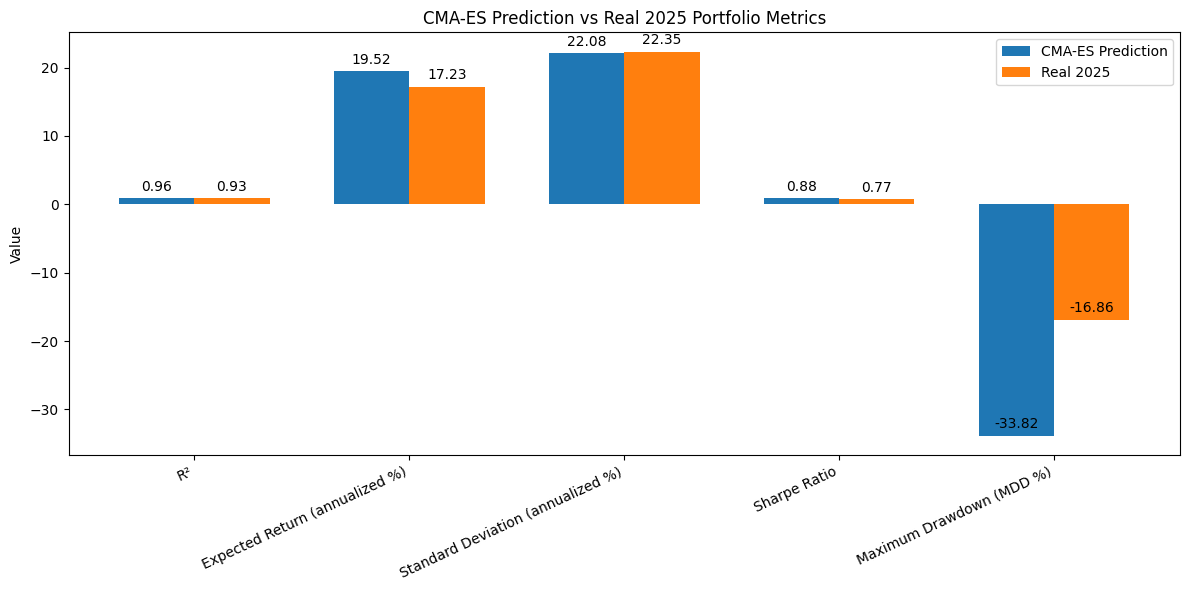

In [ ]:
# CMA-ES results
cmaes_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "CMA-ES Prediction": cmaes_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of CMA-ES Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

cmaes_vals = [cmaes_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, cmaes_vals, width, label='CMA-ES Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('CMA-ES Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Particle Swarm Optimization (PSO) ⚛️🖥️

Parameters

In [ ]:
# PSO Parameters
N_PARTICLES = 50
N_GENERATIONS = 500
W_INERTIA = 0.7
C1 = 1.5
C2 = 1.5
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


PSO Implementation

In [ ]:
# Initialization
particles = np.array([
    normalize(np.random.rand(n_assets)) for _ in range(N_PARTICLES)
])

velocities = np.zeros_like(particles)
personal_best_positions = np.copy(particles)
personal_best_scores = np.array([
    fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
    for ind in particles
])

global_best_idx = np.argmin(personal_best_scores)
global_best_position = personal_best_positions[global_best_idx]
global_best_score = personal_best_scores[global_best_idx]

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):

    for i in range(N_PARTICLES):

        r1 = np.random.rand(n_assets)
        r2 = np.random.rand(n_assets)

        cognitive = C1 * r1 * (personal_best_positions[i] - particles[i])
        social = C2 * r2 * (global_best_position - particles[i])

        velocities[i] = W_INERTIA * velocities[i] + cognitive + social
        particles[i] += velocities[i]

        particles[i] = normalize(particles[i])

        score = fitness(
            particles[i],
            real_returns,
            asset_returns_matrix,
            esg_norm,
            lambda_penalty
        )

        if score < personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i]

            if score < global_best_score:
                global_best_score = score
                global_best_position = particles[i]

    best_r2 = compute_r2(real_returns, asset_returns_matrix @ global_best_position)
    best_penalty = compute_esg_penalty(global_best_position, esg_norm)

    history_best_fitness.append(global_best_score)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(f"Gen {generation}: Fitness={global_best_score:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}")

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_weights = global_best_position
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {global_best_score:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")

Gen 0: Fitness=-0.5807, R2=0.8975, ESG Penalty=0.2112
Gen 10: Fitness=-0.7065, R2=0.9539, ESG Penalty=0.1649
Gen 20: Fitness=-0.7259, R2=0.9470, ESG Penalty=0.1474
Gen 30: Fitness=-0.7374, R2=0.9391, ESG Penalty=0.1389
Gen 40: Fitness=-0.7386, R2=0.9450, ESG Penalty=0.1382
Gen 50: Fitness=-0.7416, R2=0.9454, ESG Penalty=0.1358
Gen 60: Fitness=-0.7426, R2=0.9406, ESG Penalty=0.1348
Gen 70: Fitness=-0.7426, R2=0.9444, ESG Penalty=0.1346
Gen 80: Fitness=-0.7427, R2=0.9446, ESG Penalty=0.1346
Gen 90: Fitness=-0.7432, R2=0.9447, ESG Penalty=0.1361
Gen 100: Fitness=-0.7441, R2=0.9441, ESG Penalty=0.1337
Gen 110: Fitness=-0.7452, R2=0.9452, ESG Penalty=0.1333
Gen 120: Fitness=-0.7461, R2=0.9426, ESG Penalty=0.1310
Gen 130: Fitness=-0.7473, R2=0.9462, ESG Penalty=0.1326
Gen 140: Fitness=-0.7476, R2=0.9460, ESG Penalty=0.1323
Gen 150: Fitness=-0.7477, R2=0.9455, ESG Penalty=0.1319
Gen 160: Fitness=-0.7479, R2=0.9466, ESG Penalty=0.1325
Gen 170: Fitness=-0.7480, R2=0.9455, ESG Penalty=0.1317
Gen

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
   Symbol    Weight  Total ESG Risk score ESG Risk Level
0    AAPL  0.098508                  17.2            Low
1     ACN  0.077361                   9.8     Negligible
2    ORLY  0.058075                  12.1            Low
3      CI  0.056523                  11.6            Low
4     TMO  0.054969                  12.8            Low
5    NDAQ  0.048672                  13.1            Low
6     ESS  0.048521                  12.4            Low
7     HPE  0.046897                  10.7            Low
8     HAS  0.045490                   7.1     Negligible
9       V  0.043118                  16.7            Low
10    MSI  0.041441                  13.1            Low
11   CDNS  0.041003                  12.0            Low
12   AMAT  0.040444                  12.7            Low
13     HD  0.036280                  12.6            Low
14    PFG  0.035482                  14.2            Low
15   NFLX  0.032911                  16.4         

2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 28 assets...


/tmp/ipython-input-43-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.9214
Expected Return (annualized): 10.4477%
Standard Deviation (annualized): 23.7245%
Sharpe Ratio: 0.4404
Maximum Drawdown (MDD): -18.9031%
Average ESG Score (weighted): 13.2641


/tmp/ipython-input-43-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of PSO Prediction vs Real 2025 Performance ===
                Fitness        R²  Expected Return (annualized %)  \
PSO Prediction  -0.7773  0.947300                       19.166311   
Real 2025           NaN  0.921416                       10.447655   

                Standard Deviation (annualized %)  Sharpe Ratio  \
PSO Prediction                          22.460781      0.853323   
Real 2025                               23.724545      0.440373   

                Maximum Drawdown (MDD %)  
PSO Prediction                -34.720448  
Real 2025                     -18.903142  


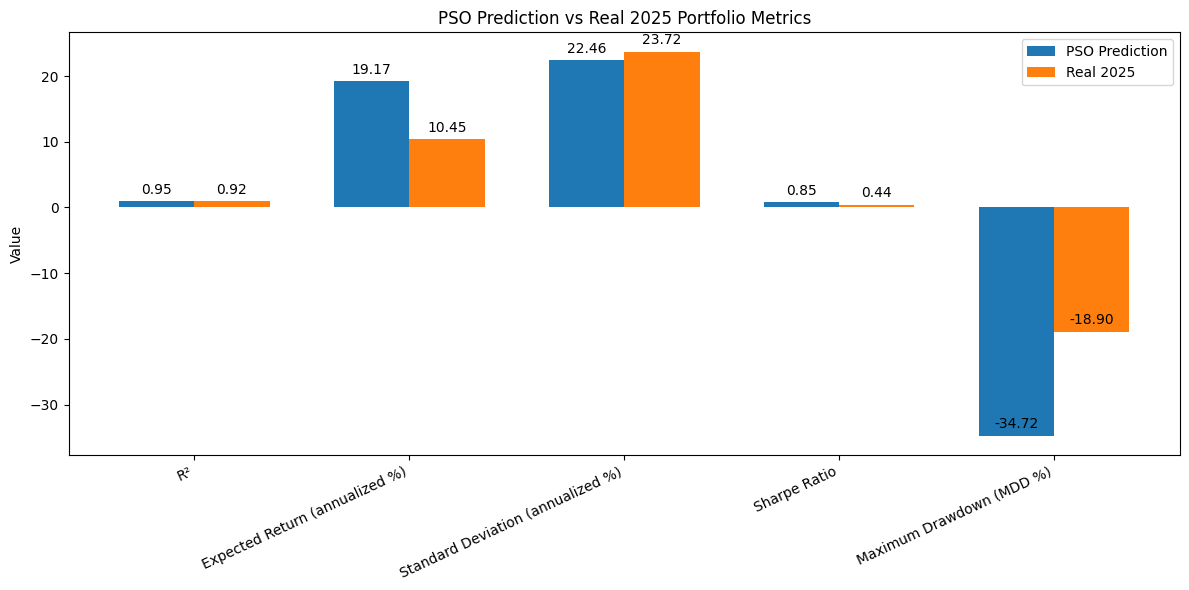

In [ ]:
# PSO results
pso_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "PSO Prediction": pso_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of PSO Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

pso_vals = [pso_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, pso_vals, width, label='PSO Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('PSO Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Simulated Annealing (SA) 🖥️

Parameters

In [ ]:
MAX_ITERATIONS = 500
INITIAL_TEMPERATURE = 1.0
FINAL_TEMPERATURE = 1e-3
ALPHA_COOLING = 0.95
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def random_neighbor(weights, perturbation_scale=0.05):
    """
    Generate a neighbor by adding small Gaussian noise and re-normalizing.
    """
    perturbation = np.random.normal(0, perturbation_scale, size=weights.shape)
    neighbor = weights + perturbation
    return normalize(neighbor)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

SA Implementation

In [ ]:
# Execution
current_weights = normalize(np.random.rand(n_assets))
current_fitness = fitness(current_weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)

best_weights = current_weights.copy()
best_fitness = current_fitness

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

temperature = INITIAL_TEMPERATURE

start_time = time.time()

for iteration in range(MAX_ITERATIONS):
    # Generate neighbor
    candidate_weights = random_neighbor(current_weights)
    candidate_fitness = fitness(candidate_weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)

    delta_fitness = candidate_fitness - current_fitness

    # Accept if better or with probability exp(-delta / T)
    if delta_fitness < 0 or np.random.rand() < np.exp(-delta_fitness / temperature):
        current_weights = candidate_weights
        current_fitness = candidate_fitness

        if current_fitness < best_fitness:
            best_weights = current_weights.copy()
            best_fitness = current_fitness

    # Store history
    best_r2 = compute_r2(real_returns, asset_returns_matrix @ best_weights)
    best_penalty = compute_esg_penalty(best_weights, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if iteration % 50 == 0 or iteration == MAX_ITERATIONS - 1:
        print(
            f"Iter {iteration}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}, Temp={temperature:.5f}"
        )

    # Cooling schedule
    temperature = max(FINAL_TEMPERATURE, temperature * ALPHA_COOLING)

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_weights = best_weights
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {best_fitness:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Iter 0: Fitness=-0.5615, R2=0.8836, ESG Penalty=0.2148, Temp=1.00000
Iter 50: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.07694
Iter 100: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00592
Iter 150: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00100
Iter 200: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00100
Iter 250: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00100
Iter 300: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00100
Iter 350: Fitness=-0.6065, R2=0.9150, ESG Penalty=0.2057, Temp=0.00100
Iter 400: Fitness=-0.6077, R2=0.9118, ESG Penalty=0.2027, Temp=0.00100
Iter 450: Fitness=-0.6077, R2=0.9118, ESG Penalty=0.2027, Temp=0.00100
Iter 499: Fitness=-0.6077, R2=0.9118, ESG Penalty=0.2027, Temp=0.00100

==== Final Results ====
Fitness: -0.6077
R²: 0.9118
Expected Return (annualized): 16.2545%
Standard Deviation (annualized): 22.1833%
Sharpe Ratio: 0.7327
Maximum Drawdown (MDD): -36.2292%
ESG Penalty: 0.2027
Execution Tim

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0     CSGP  0.014875                  21.9         Medium
1       TT  0.014843                  15.2            Low
2      KMB  0.014571                  28.5         Medium
3     FTNT  0.014037                  18.9            Low
4     ADBE  0.013756                  13.1            Low
..     ...       ...                   ...            ...
225    MTD  0.000162                  13.1            Low
226   HUBB  0.000152                  19.6            Low
227    CSX  0.000129                  21.9         Medium
228    SYK  0.000123                  28.3         Medium
229    CNP  0.000113                  28.7         Medium

[230 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 230 assets...


/tmp/ipython-input-48-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8968
Expected Return (annualized): 16.6700%
Standard Deviation (annualized): 21.9030%
Sharpe Ratio: 0.7611
Maximum Drawdown (MDD): -15.2404%
Average ESG Score (weighted): 20.2698


/tmp/ipython-input-48-3013261169.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2025 = adj_close_2025.pct_change().dropna()
/tmp/ipython-input-48-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of SA Prediction vs Real 2025 Performance ===
               Fitness        R²  Expected Return (annualized %)  \
SA Prediction  -0.7773  0.911796                       16.254457   
Real 2025          NaN  0.896797                       16.669997   

               Standard Deviation (annualized %)  Sharpe Ratio  \
SA Prediction                          22.183256      0.732735   
Real 2025                              21.902959      0.761084   

               Maximum Drawdown (MDD %)  
SA Prediction                -36.229209  
Real 2025                    -15.240408  


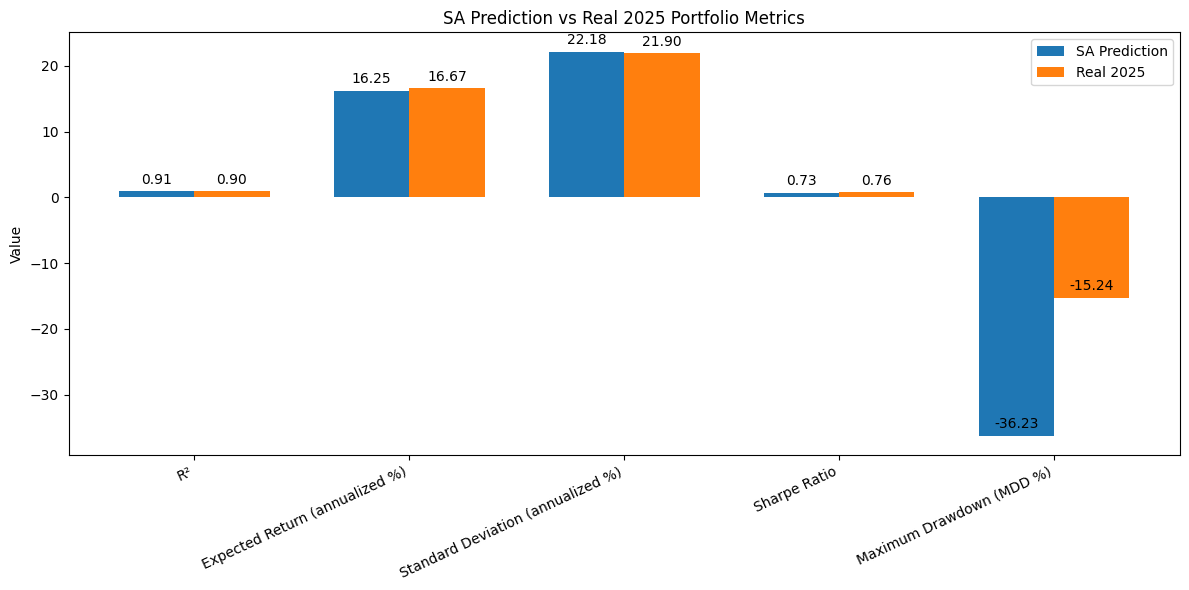

In [ ]:
# SA results
sa_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "SA Prediction": sa_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of SA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

sa_vals = [sa_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, sa_vals, width, label='SA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('SA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Firefly Algorithm (FA) 🖥️🦋✨

Parameters

In [ ]:
N_FIREFLIES = 50
N_GENERATIONS = 500
BETA0 = 1.0
GAMMA = 1.0
ALPHA = 0.2
lambda_penalty = 1.5

n_assets = asset_returns_matrix.shape[1]

# Helper Functions
def normalize(weights):
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

def initialize_population(n_fireflies, n_assets):
    return np.array([normalize(np.random.rand(n_assets)) for _ in range(n_fireflies)])

def distance(w1, w2):
    return np.linalg.norm(w1 - w2)

def move_firefly(xi, xj, beta, alpha):
    rand = np.random.uniform(-1, 1, size=xi.shape)
    new_pos = xi + beta * (xj - xi) + alpha * rand
    return normalize(new_pos)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def compute_esg_penalty(weights, esg_norm):
    return np.sum(weights * esg_norm)

def fitness(weights, real_returns, asset_returns_matrix, esg_norm, lambda_penalty):
    weights = weights / np.sum(weights)
    portfolio_returns = asset_returns_matrix @ weights
    r2 = compute_r2(real_returns, portfolio_returns)
    esg_penalty = compute_esg_penalty(weights, esg_norm)
    return -r2 + lambda_penalty * esg_penalty

# Financial Metrics
def portfolio_expected_return(weights, asset_returns_matrix):
    mean_daily = np.mean(asset_returns_matrix @ weights)
    annualized = mean_daily * 252
    return annualized

def portfolio_std(weights, asset_returns_matrix):
    daily_std = np.std(asset_returns_matrix @ weights)
    annualized = daily_std * np.sqrt(252)
    return annualized

def portfolio_sharpe(weights, asset_returns_matrix, risk_free_rate=0.0):
    exp_ret = portfolio_expected_return(weights, asset_returns_matrix)
    std_dev = portfolio_std(weights, asset_returns_matrix)
    if std_dev == 0:
        return 0
    return (exp_ret - risk_free_rate) / std_dev

def portfolio_mdd(weights, asset_returns_matrix):
    cumulative = (asset_returns_matrix @ weights + 1).cumprod()
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


FA Implementation

In [ ]:
# Execution
fireflies = initialize_population(N_FIREFLIES, n_assets)

fitness_scores = np.array([
    fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
    for ind in fireflies
])

history_best_fitness = []
history_best_r2 = []
history_best_penalty = []

start_time = time.time()

for generation in range(N_GENERATIONS):

    for i in range(N_FIREFLIES):
        for j in range(N_FIREFLIES):
            if fitness_scores[j] < fitness_scores[i]:
                rij = distance(fireflies[i], fireflies[j])
                beta = BETA0 * np.exp(-GAMMA * rij ** 2)
                fireflies[i] = move_firefly(fireflies[i], fireflies[j], beta, ALPHA)

    # Update fitness after movement
    fitness_scores = np.array([
        fitness(ind, real_returns, asset_returns_matrix, esg_norm, lambda_penalty)
        for ind in fireflies
    ])

    best_idx = np.argmin(fitness_scores)
    best_firefly = fireflies[best_idx]
    best_fitness = fitness_scores[best_idx]

    best_r2 = compute_r2(
        real_returns,
        asset_returns_matrix @ best_firefly
    )
    best_penalty = compute_esg_penalty(best_firefly, esg_norm)

    history_best_fitness.append(best_fitness)
    history_best_r2.append(best_r2)
    history_best_penalty.append(best_penalty)

    if generation % 10 == 0 or generation == N_GENERATIONS - 1:
        print(
            f"Gen {generation}: Fitness={best_fitness:.4f}, R2={best_r2:.4f}, ESG Penalty={best_penalty:.4f}"
        )

end_time = time.time()
exec_time = end_time - start_time

# Final Metrics
final_best_idx = np.argmin(fitness_scores)
final_best_weights = fireflies[final_best_idx]
final_best_r2 = compute_r2(real_returns, asset_returns_matrix @ final_best_weights)
final_best_penalty = compute_esg_penalty(final_best_weights, esg_norm)

exp_return = portfolio_expected_return(final_best_weights, asset_returns_matrix)
std_dev = portfolio_std(final_best_weights, asset_returns_matrix)
sharpe_ratio = portfolio_sharpe(final_best_weights, asset_returns_matrix)
mdd = portfolio_mdd(final_best_weights, asset_returns_matrix)

print("\n==== Final Results ====")
print(f"Fitness: {fitness_scores[final_best_idx]:.4f}")
print(f"R²: {final_best_r2:.4f}")
print(f"Expected Return (annualized): {exp_return:.4%}")
print(f"Standard Deviation (annualized): {std_dev:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown (MDD): {mdd:.4%}")
print(f"ESG Penalty: {final_best_penalty:.4f}")
print(f"Execution Time: {exec_time:.2f} seconds")

# Top 10 Portfolio Assets
top_assets_idx = np.argsort(-final_best_weights)[:10]
top_assets = [returns.columns[i] for i in top_assets_idx]
top_weights = final_best_weights[top_assets_idx]

print("\nTop 10 Portfolio Assets:")
for name, weight in zip(top_assets, top_weights):
    print(f"{name}: {weight:.4f}")


Gen 0: Fitness=-0.5886, R2=0.9043, ESG Penalty=0.2105
Gen 10: Fitness=-0.6029, R2=0.9125, ESG Penalty=0.2064
Gen 20: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 30: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 40: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 50: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 60: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 70: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 80: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 90: Fitness=-0.6076, R2=0.9183, ESG Penalty=0.2071
Gen 100: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 110: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 120: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 130: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 140: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 150: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 160: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen 170: Fitness=-0.6096, R2=0.9164, ESG Penalty=0.2045
Gen

Full Portfolio Description

In [ ]:
# Creation of final result DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': common_symbols,
    'Weight': final_best_weights
})

# Join with previous ESG DataFrame
portfolio_df = portfolio_df.merge(
    esg_df[['Total ESG Risk score', 'ESG Risk Level']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Filter assets with significant weight
portfolio_df = portfolio_df[portfolio_df['Weight'] > 0.0001]

# Organize
portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Show final results
print("\n=== FULL PORTFOLIO WITH ESG INFO ===")
print(portfolio_df)

# Export to CSV
portfolio_df.to_csv("optimized_portfolio_with_esg.csv", index=False)


=== FULL PORTFOLIO WITH ESG INFO ===
    Symbol    Weight  Total ESG Risk score ESG Risk Level
0      ACN  0.008947                   9.8     Negligible
1      AWK  0.008940                  21.6         Medium
2     AMZN  0.008890                  30.6           High
3     ANSS  0.008712                  15.9            Low
4     ILMN  0.008710                  18.6            Low
..     ...       ...                   ...            ...
218    MGM  0.000236                  24.8         Medium
219    BIO  0.000223                  17.4            Low
220    MET  0.000181                  16.4            Low
221    HAS  0.000162                   7.1     Negligible
222    AZO  0.000100                  11.0            Low

[223 rows x 4 columns]


2025 first semester data for comparison

In [ ]:
# Settings

start_2025 = "2025-01-01"
end_2025 = "2025-06-30"


final_assets = portfolio_df['Symbol'].tolist()
weights_vector = portfolio_df['Weight'].values


final_assets = [t for t in final_assets if isinstance(t, str) and t.strip() != ""]

print(f"Testing your optimized portfolio on 2025 with {len(final_assets)} assets...")

# Get 2025 data

price_data_2025 = yf.download(
    final_assets,
    start=start_2025,
    end=end_2025,
    group_by='ticker',
    progress=False
)

# Extract adjusted prices
adj_close_dict = {}

for ticker in final_assets:
    try:
        adj_close = price_data_2025[ticker]['Close']
        if not adj_close.isnull().all():
            adj_close_dict[ticker] = adj_close
        else:
            print(f"No valid Adj Close for {ticker}")
    except (KeyError, AttributeError, IndexError):
        print(f"Ticker {ticker} not in downloaded data")

# Create final DataFrame
if adj_close_dict:
    adj_close_2025 = pd.DataFrame(adj_close_dict)
else:
    adj_close_2025 = pd.DataFrame()

# Calculate daily returns

if adj_close_2025.empty:
    print("No valid price data for any ticker in 2025. Aborting.")
else:
    returns_2025 = adj_close_2025.pct_change().dropna()

# Get 2025 benchmark results

    benchmark_data_2025 = yf.download(
        "^GSPC",
        start=start_2025,
        end=end_2025,
        progress=False
    )

    if benchmark_data_2025.empty:
        print("No benchmark data for 2025. Aborting.")
    else:
        if "Adj Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Adj Close"]
        elif "Close" in benchmark_data_2025.columns:
            bench_series = benchmark_data_2025["Close"]
        else:
            raise ValueError("Benchmark data missing 'Close' or 'Adj Close' columns.")

        benchmark_returns_2025 = bench_series.pct_change().dropna()

        # Align Dates
        common_dates = returns_2025.index.intersection(benchmark_returns_2025.index)

        returns_2025 = returns_2025.loc[common_dates]
        benchmark_returns_2025 = benchmark_returns_2025.loc[common_dates]

        # Filter weights
        cols_existing = [c for c in returns_2025.columns if c in portfolio_df['Symbol'].values]

        returns_2025 = returns_2025[cols_existing]
        weights_vector_filtered = portfolio_df.loc[
            portfolio_df['Symbol'].isin(cols_existing),
            'Weight'
        ].values

        # Calculate portfolio returns

        # Weights vector
        weights_vector = weights_vector_filtered

        portfolio_returns_2025 = returns_2025.values @ weights_vector

        # Metrics

        start_time = time.time()

        # R²
        r2_2025 = r2_score(benchmark_returns_2025.values, portfolio_returns_2025)

        # Expected annual return
        mean_daily_return = np.mean(portfolio_returns_2025)
        expected_return_annual = (1 + mean_daily_return) ** 252 - 1

        # Standard deviation
        std_dev_annual = np.std(portfolio_returns_2025) * np.sqrt(252)

        # Sharpe ratio
        if std_dev_annual > 0:
            sharpe_ratio_2025 = expected_return_annual / std_dev_annual
        else:
            sharpe_ratio_2025 = np.nan

        # Maximum Drawdown
        portfolio_returns_series = pd.Series(portfolio_returns_2025, index=common_dates)

        cumulative = (1 + portfolio_returns_series).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        mdd_benchmark = drawdowns.min()

        # Filter dataframe to only the assets in the portfolio
        esg_sub_df = esg_df.loc[cols_existing]
        esg_scores_portfolio = esg_sub_df["Total ESG Risk score"].values
        esg_average = np.sum(weights_vector * esg_scores_portfolio)

        # Show results

        print("\n==== TEST RESULTS on 2025 ====")
        print(f"R²: {r2_2025:.4f}")
        print(f"Expected Return (annualized): {expected_return_annual*100:.4f}%")
        print(f"Standard Deviation (annualized): {std_dev_annual*100:.4f}%")
        print(f"Sharpe Ratio: {sharpe_ratio_2025:.4f}")
        print(f"Maximum Drawdown (MDD): {mdd_benchmark*100:.4f}%")
        print(f"Average ESG Score (weighted): {esg_average:.4f}")

Testing your optimized portfolio on 2025 with 223 assets...


/tmp/ipython-input-53-3013261169.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_2025 = yf.download(



==== TEST RESULTS on 2025 ====
R²: 0.8909
Expected Return (annualized): 13.5639%
Standard Deviation (annualized): 21.4862%
Sharpe Ratio: 0.6313
Maximum Drawdown (MDD): -15.5975%
Average ESG Score (weighted): 20.3912


/tmp/ipython-input-53-3013261169.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data_2025 = yf.download(


Real vs. Predicted Values Visualization

=== Comparison of FA Prediction vs Real 2025 Performance ===
                Fitness        R²  Expected Return (annualized %)  \
FA Prediction -0.617045  0.922958                       15.373991   
Real 2025           NaN  0.890881                       13.563902   

               Standard Deviation (annualized %)  Sharpe Ratio  \
FA Prediction                          21.881002      0.702618   
Real 2025                              21.486213      0.631284   

               Maximum Drawdown (MDD %)  
FA Prediction                -36.882887  
Real 2025                    -15.597516  


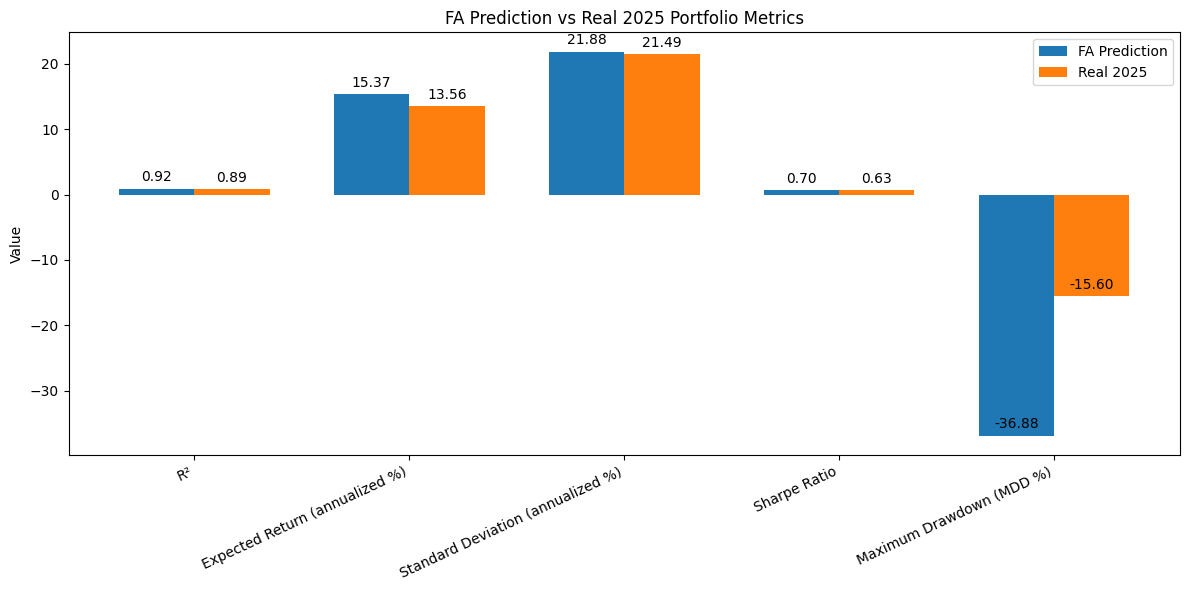

In [ ]:
# FA results
fa_results = {
    "Fitness": fitness_scores[final_best_idx],
    "R²": final_best_r2,
    "Expected Return (annualized %)": exp_return * 100,
    "Standard Deviation (annualized %)": std_dev * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (MDD %)": mdd * 100,
}

# Real 2025 results
test_2025_results = {
    "Fitness": np.nan,
    "R²": r2_2025,
    "Expected Return (annualized %)": expected_return_annual * 100,
    "Standard Deviation (annualized %)": std_dev_annual * 100,
    "Sharpe Ratio": sharpe_ratio_2025,
    "Maximum Drawdown (MDD %)": mdd_benchmark * 100,
}

# Create comparative DataFrame
df_compare = pd.DataFrame({
    "FA Prediction": fa_results,
    "Real 2025": test_2025_results
}).T

print("=== Comparison of FA Prediction vs Real 2025 Performance ===")
print(df_compare)

# Make graphic
metrics = ["R²", "Expected Return (annualized %)", "Standard Deviation (annualized %)", "Sharpe Ratio", "Maximum Drawdown (MDD %)"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

fa_vals = [fa_results[m] for m in metrics]
test_vals = [test_2025_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, fa_vals, width, label='FA Prediction')
bars2 = ax.bar(x + width/2, test_vals, width, label='Real 2025')

ax.set_ylabel('Value')
ax.set_title('FA Prediction vs Real 2025 Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha='right')
ax.legend()

# Show values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()